In [4]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class DatasetSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

In [5]:
import glob
import os
import cv2

import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

image_shape=(200, 66)

def get_images(list_images, type_image):
    # Read the images
    array_imgs = []
    for name in list_images:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        #img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        img = cv2.resize(img, image_shape)

        array_imgs.append(img)

    return array_imgs

def parse_json(data):
    # Process json
    array_annotations_v = []
    array_annotations_w = []
    array = []
    data_parse = data.split('}')[:-1]

    for number, d in enumerate(data_parse):
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array_annotations_v.append(float(v))
        array_annotations_w.append(float(w))
        array.append((float(v), float(w)))
    return array

def flip_images(images, array_annotations):
    flipped_images = []
    flipped_annotations = []
    for i, image in enumerate(images):
        flipped_images.append(cv2.flip(image, 1))
        flipped_annotations.append((array_annotations[i][0], -array_annotations[i][1]))

    images += flipped_images
    array_annotations += flipped_annotations
    return images, array_annotations

def add_extreme_data(images, array_annotations):
    for i in range(0, len(array_annotations)):
        if abs(array_annotations[i][1]) >= 1:
            if abs(array_annotations[i][1]) >= 2:
                num_iter = 10
                # num_iter = 15
                # num_iter = 20
            else:
                num_iter = 5
                # num_iter = 10
                # num_iter = 15
            for j in range(0, num_iter):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
        if float(array_annotations[i][0]) <= 2:
            for j in range(0, 1):
            #for j in range(0, 5):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
                
    return images, array_annotations

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

print('---- train ----')
train_name_file = '../complete_dataset/Train/train.json'
file_train = open(train_name_file, 'r')
data_train = file_train.read()
file_train.close()

array_annotations_train = []
DIR_train_images = '../complete_dataset/Train/Images/'
list_images_train = glob.glob(DIR_train_images + '*')
images_paths_train = sorted(list_images_train, key=lambda x: int(x.split('/')[4].split('.png')[0]))
#print(images_paths_train)
array_annotations_train = parse_json(data_train)
print(type(images_paths_train))
print(len(images_paths_train))
print(images_paths_train[0])
print(type(array_annotations_train))
print(array_annotations_train[0])
print(len(array_annotations_train))

images_train = get_images(images_paths_train, 'cropped')
print(len(images_train))
print(type(images_train))
images_train, array_annotations_train = flip_images(images_train, array_annotations_train)
print(len(images_train))
print(type(images_train))
print(len(array_annotations_train))
images_train, array_annotations_train = add_extreme_data(images_train, array_annotations_train)
print(len(images_train))
print(type(images_train))
print(len(array_annotations_train))

array_annotations_v = []
array_annotations_w = []
for annotation in array_annotations_train:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])
    
array_annotations_train = normalized_annotations

print(len(images_train))
print(type(images_train))
print(len(array_annotations_train))

print('---- val ----')
test_name_file = '../complete_dataset/Test/test.json'
file_test = open(test_name_file, 'r')
data_test = file_test.read()
file_test.close()

DIR_test_images = '../complete_dataset/Test/Images/'
list_images_val = glob.glob(DIR_test_images + '*')
images_paths_val = sorted(list_images_val, key=lambda x: int(x.split('/')[4].split('.png')[0]))
array_annotations_val = parse_json(data_test)
print(type(images_paths_val))
print(len(images_paths_val))
print(images_paths_val[0])
print(type(array_annotations_val))
print(array_annotations_val[0])
print(len(array_annotations_val))

images_val = get_images(images_paths_val, 'cropped')
print(len(images_val))
print(type(images_val))
images_val, array_annotations_val = flip_images(images_val, array_annotations_val)
print(len(images_val))
print(type(images_val))
print(len(array_annotations_val))
images_val, array_annotations_val = add_extreme_data(images_val, array_annotations_val)
print(len(images_val))
print(type(images_val))
print(len(array_annotations_val))


array_annotations_v = []
array_annotations_w = []
for annotation in array_annotations_val:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])
    
array_annotations_val = normalized_annotations

print(len(images_val))
print(type(images_val))
print(len(array_annotations_val))

---- train ----
<class 'list'>
12138
../complete_dataset/Train/Images/0.png
<class 'list'>
(5.0, -0.518)
12138
12138
<class 'list'>
24276
<class 'list'>
24276
39154
<class 'list'>
39154
39154
<class 'list'>
39154
---- val ----
<class 'list'>
5203
../complete_dataset/Test/Images/0.png
<class 'list'>
(5.0, -0.7216)
5203
5203
<class 'list'>
10406
<class 'list'>
10406
16192
<class 'list'>
16192
16192
<class 'list'>
16192


--- ANNOTATIONS DATA ---


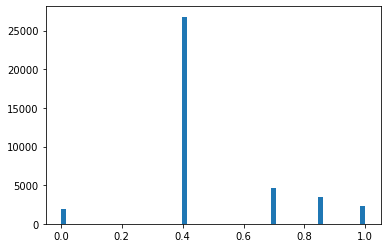

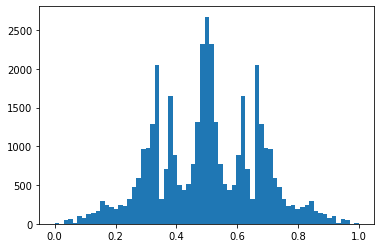

--- VALIDATION DATA ---


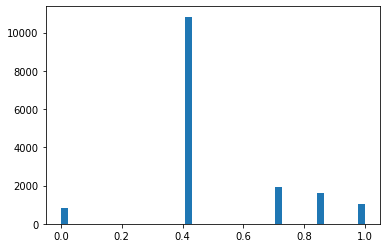

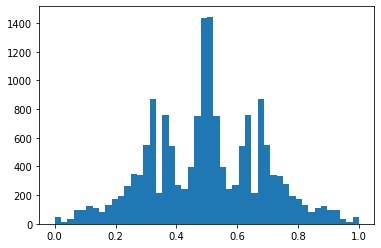

In [9]:
print('--- ANNOTATIONS DATA ---')
ann_x = []
ann_y = []
for ann in array_annotations_train:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- VALIDATION DATA ---')
ann_x = []
ann_y = []
for ann in array_annotations_val:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0 26 32]
  [ 0 26 32]
  [ 0 26 32]]

 [[60 56 57]
  [61 57 58]
  [62 58 59]
  ...
  [ 0 26 32]
  [ 0 26 32]
  [ 0 26 32]]

 [[63 59 59]
  [62 58 59]
  [61 57 58]
  ...
  [ 0 26 32]
  [ 0 26 32]
  [ 0 26 32]]

 ...

 [[72 67 69]
  [70 66 67]
  [66 62 63]
  ...
  [68 60 62]
  [67 61 62]
  [65 60 61]]

 [[62 59 60]
  [60 56 57]
  [58 54 55]
  ...
  [69 59 63]
  [70 60 64]
  [72 61 65]]

 [[53 49 50]
  [52 48 49]
  [52 49 49]
  ...
  [67 57 60]
  [69 58 62]
  [70 60 64]]]
[0.4117647058823529, 0.4168218896525146]
<class 'list'>
[0.4117647058823529, 0.5831781103474855]
<class 'list'>
[0.4117647058823529, 0.3732255797610682]
<class 'list'>
[0.4117647058823529, 0.6267744202389318]
<class 'list'>


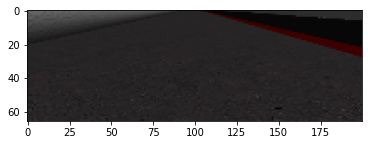

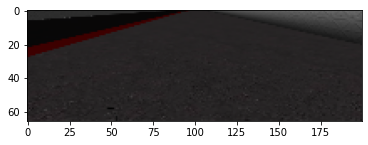

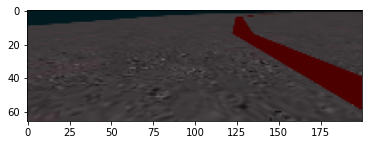

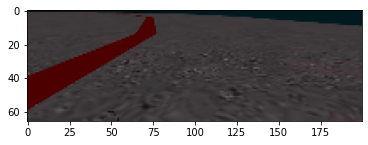

<Figure size 432x288 with 0 Axes>

In [10]:
print(images_val[5203])
plt.imshow(images_train[0])
plt.figure()
print(array_annotations_train[0])
print(type(array_annotations_train[0]))
plt.imshow(images_train[12138])
plt.figure()
print(array_annotations_train[12138])
print(type(array_annotations_train[12138]))


plt.imshow(images_val[0])
plt.figure()
print(array_annotations_val[0])
print(type(array_annotations_val[0]))
plt.imshow(images_val[5203])
plt.figure()
print(array_annotations_val[5203])
print(type(array_annotations_val[5203]))

In [11]:
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize, ColorJitter, ChannelShuffle, Equalize
)

AUGMENTATIONS_TRAIN = Compose([
    RandomBrightnessContrast(),
    HueSaturationValue(),
    FancyPCA(),
    RandomGamma(),
    GaussianBlur(),
    GaussNoise(),
    #
    #ColorJitter(),
    #Equalize(),
    #ChannelShuffle(),
    #
    Normalize()
])

AUGMENTATIONS_TEST = Compose([
    Normalize()
])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Dropout, ConvLSTM2D, Reshape, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam


def pilotnet_model(img_shape):
    '''
    Model of End to End Learning for Self-Driving Cars (NVIDIA)
    '''
    model = Sequential()
    model.add(BatchNormalization(epsilon=0.001, axis=-1, input_shape=img_shape))
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu",padding='same'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu",padding='same'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu",padding='same'))
    model.add(Flatten())
    model.add(Dense(1164, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2))
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss="mse", metrics=['mse', 'mae'])
    return model

In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger
import datetime

timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
#img_shape = (60, 160, 3)
img_shape = (66, 200, 3)

hparams = {
    'train_batch_size': 50, 
    'val_batch_size': 50,
    'batch_size': 50,
    'n_epochs': 100, 
    'checkpoint_dir': '../logs_test/'
}

print(hparams)

model_name = 'pilotnet_model'
model = pilotnet_model(img_shape)
model_filename = timestr + '_pilotnet_model_100_all_n_extreme_albumentations__crop'
model_file = model_filename + '.h5'


# Training data
train_gen = DatasetSequence(images_train, array_annotations_train, hparams['batch_size'], augmentations=AUGMENTATIONS_TRAIN)

# Validation data
valid_gen = DatasetSequence(images_val, array_annotations_val, hparams['batch_size'], augmentations=AUGMENTATIONS_TEST)
#valid_gen = DatasetSequence(images_val, array_annotations_val, hparams['batch_size'], augmentations=AUGMENTATIONS_TRAIN)


# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="mae", patience=30, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='mse', save_best_only=True, verbose=1)
csv_logger = CSVLogger(model_filename + '.csv', append=True)

# Print layers
print(model)
model.build(img_shape)
print(model.summary())
# Training
model.fit(
    train_gen,
    epochs=hparams['n_epochs'],
    verbose=2,
    validation_data=valid_gen,
    #workers=2, use_multiprocessing=False,
    callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)


# Evaluate the model
score = model.evaluate_generator(valid_gen, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = hparams['train_batch_size']
    f.attrs['nb_epoch'] = hparams['n_epochs']
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(array_annotations_train)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

20210712-112257
{'train_batch_size': 50, 'val_batch_size': 50, 'batch_size': 50, 'n_epochs': 100, 'checkpoint_dir': '../logs_test/'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 66, 200, 3)        12        
_________________________________________________________________
conv2d (Conv2D)              (None, 33, 100, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 50, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 25, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 25, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 25, 64)         

In [2]:

import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


def load_data(folder):
    name_folder = '../' + folder + '/Images/'
    list_images = glob.glob(name_folder + '*')
    print(list_images[0])
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.png')[0]))
    name_file = '../' + folder + '/data.json'
    file = open(name_file, 'r')
    data = file.read()
    file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    data_parse = data.split('}')[:-1]
    for d in data_parse:
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


def add_extreme_data(array, imgs):
    for i in range(0, len(array)):
        if abs(array[i][1]) >= 1:
            if abs(array[i][1]) >= 2:
                num_iter = 10
            else:
                num_iter = 5
            for j in range(0, num_iter):
                array.append(array[i])
                imgs.append(imgs[i])
        if float(array[i][0]) <= 2:
            for j in range(0, 1):
                array.append(array[i])
                imgs.append(imgs[i])
    return array, imgs


# Load data
images, data = load_data('complete_dataset')
images_curve, data_curve = load_data('curves_only')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
array_imgs = get_images(images_curve, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
array_annotations = parse_json(data_curve, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]
array_annotations, array_imgs = add_extreme_data(array_annotations, array_imgs)

# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])

array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)
# normalized_Y = normalize(array_annotations_w)
'''
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)
'''

print(normalized_Y)

old_min = normalized_Y.min()
print('NEW MIN -> ' + str(old_min))
old_range = normalized_Y.max() - old_min
print('NEW RANGE -> ' + str(old_range))

old_min = array_annotations_w.min()
print('OLD MIN -> ' + str(old_min))
old_range = array_annotations_w.max() - old_min
print('OLD RANGE -> ' + str(old_range))


normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA

split_test_train_value = 0.30
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=0.30, random_state=42)
# FOR LSTMs -> suffle=False because the order of images is relevant
images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=split_test_train_value, random_state=42, shuffle=True)
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_2_images, array_annotations, test_size=0.30, random_state=42)

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

print(annotations_train[0])
print(annotations_train.shape)

#video = np.stack(array_imgs, axis=0)
print(images_train.shape)
print(images_validation.shape)


../complete_dataset/Images/2257.png
../curves_only/Images/2257.png
[[0.50473698]
 [0.50433554]
 [0.50738647]
 ...
 [0.72978354]
 [0.72978354]
 [0.72978354]]
NEW MIN -> 0.0
NEW RANGE -> 1.0
OLD MIN -> -3.1138
OLD RANGE -> 6.2276
[0.41176471 0.18411587]
(47672, 2)
(47672, 60, 160, 3)
(20432, 60, 160, 3)


(47672, 60, 160, 3)
[0.41016516 0.7331173 ]
[[[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[ 58  57  58]
  [ 58  57  58]
  [ 58  57  57]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 ...

 [[ 49  46  46]
  [ 44  41  41]
  [ 36  33  34]
  ...
  [  9   9   9]
  [  8   8   8]
  [  9   9   9]]

 [[ 49  47  47]
  [ 42  40  40]
  [ 46  43  43]
  ...
  [  9   9   9]
  [  9   8   9]
  [  8   8   8]]

 [[ 48  45  46]
  [ 44  41  42]
  [ 42  39  39]
  ...
  [  9   9   9]
  [  9   9   9]
  [ 11  10  10]]]
[0.41176471 0.73940202]


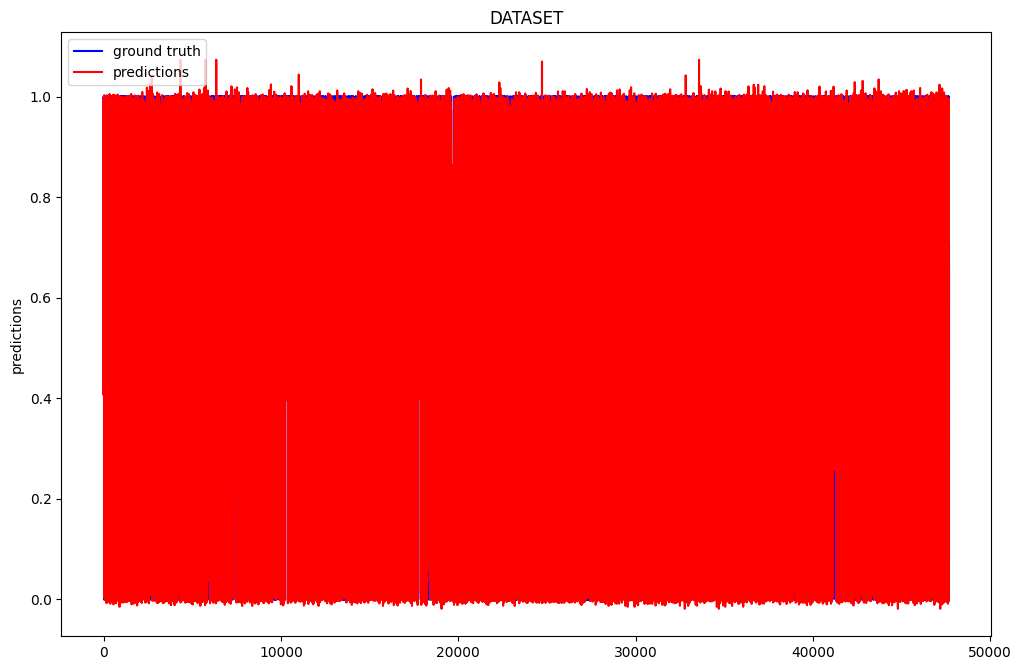

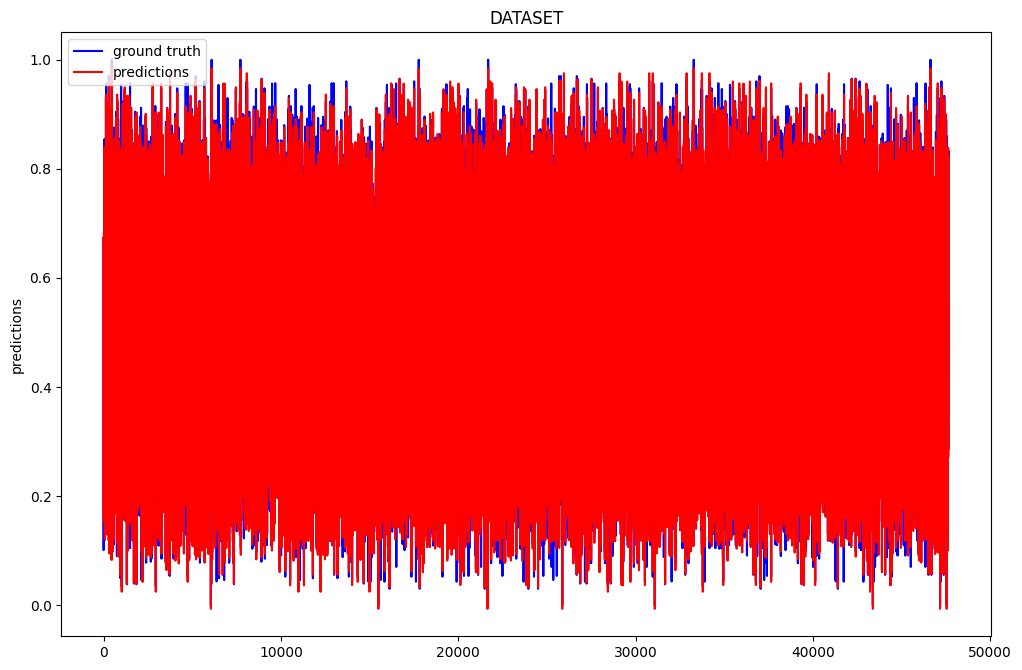

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize
)



regression_model = load_model('20210706-141937_pilotnet_model_100_all_n_extreme_albumentations_cp.h5')

AUGMENTATIONS_TEST = Compose([
    Normalize()
])
normalized_images = []
for image in images_train:
    image = AUGMENTATIONS_TEST(image=image)['image']
    normalized_images.append(image)
normalized_images = np.stack(normalized_images, axis=0)
print(normalized_images.shape)
predictions_train = regression_model.predict(normalized_images)

print(predictions_train[100])
#print(predictions_train[:,1])

print(images_train[100])
print(annotations_train[100])


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,0], "-b", label="ground truth")
plt.plot(predictions_train[:,0], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('DATASET')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('DATASET')
plt.show()


In [4]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '../' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    #print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[2].split('.png')[0]))
    name_file = '../' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in data.items():
        v = data[key]['v']
        w = data[key]['w']
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('simple_circuit_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])

array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)


normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_simple = np.stack(array_imgs, axis=0)
annotations_simple = np.stack(array_annotations, axis=0)

print(images_simple.shape)
print(annotations_simple.shape)

(3550, 60, 160, 3)
(3550, 2)


(3550, 60, 160, 3)
[0.40544772 0.33815366]
[[[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[ 58  57  58]
  [ 58  57  58]
  [ 58  57  57]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 ...

 [[ 49  46  46]
  [ 44  41  41]
  [ 36  33  34]
  ...
  [  9   9   9]
  [  8   8   8]
  [  9   9   9]]

 [[ 49  47  47]
  [ 42  40  40]
  [ 46  43  43]
  ...
  [  9   9   9]
  [  9   8   9]
  [  8   8   8]]

 [[ 48  45  46]
  [ 44  41  42]
  [ 42  39  39]
  ...
  [  9   9   9]
  [  9   9   9]
  [ 11  10  10]]]
[0.41176471 0.16367106]


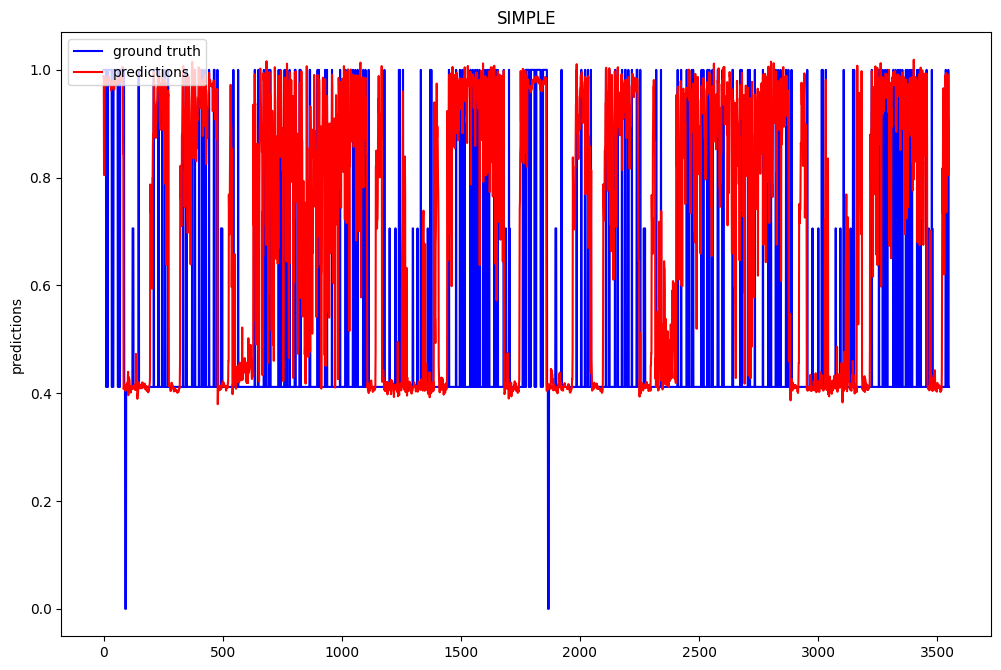

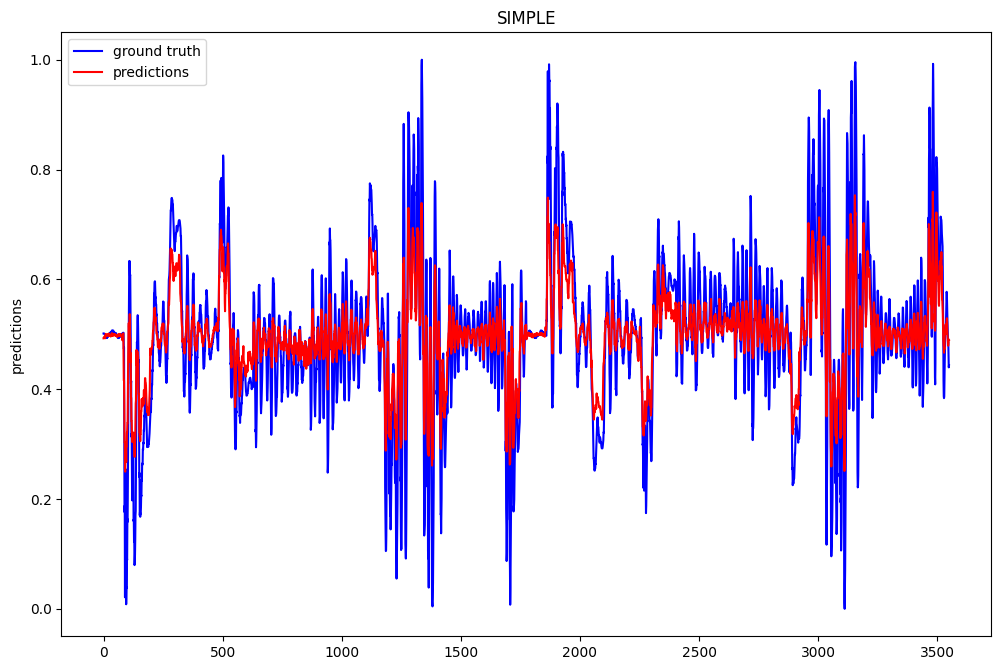

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize
)


regression_model = load_model('20210706-141937_pilotnet_model_100_all_n_extreme_albumentations_cp.h5')

AUGMENTATIONS_TEST = Compose([
    Normalize()
])
normalized_images = []
for image in images_simple:
    image = AUGMENTATIONS_TEST(image=image)['image']
    normalized_images.append(image)
normalized_images = np.stack(normalized_images, axis=0)
print(normalized_images.shape)
predictions_train = regression_model.predict(normalized_images)

print(predictions_train[100])
#print(predictions_train[:,1])

print(images_train[100])
print(annotations_simple[100])


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,0], "-b", label="ground truth")
plt.plot(predictions_train[:,0], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('SIMPLE')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('SIMPLE')
plt.show()


In [6]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '../' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    #print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[2].split('.png')[0]))
    name_file = '../' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in data.items():
        v = data[key]['v']
        w = data[key]['w']
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('many_curves_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])

array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_many_curves = np.stack(array_imgs, axis=0)
annotations_many_curves = np.stack(array_annotations, axis=0)

print(images_many_curves.shape)
print(annotations_many_curves.shape)


(5526, 60, 160, 3)
(5526, 2)


(5526, 60, 160, 3)
[0.7082387 0.5454715]
[[[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[ 58  57  58]
  [ 58  57  58]
  [ 58  57  57]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 ...

 [[ 49  46  46]
  [ 44  41  41]
  [ 36  33  34]
  ...
  [  9   9   9]
  [  8   8   8]
  [  9   9   9]]

 [[ 49  47  47]
  [ 42  40  40]
  [ 46  43  43]
  ...
  [  9   9   9]
  [  9   8   9]
  [  8   8   8]]

 [[ 48  45  46]
  [ 44  41  42]
  [ 42  39  39]
  ...
  [  9   9   9]
  [  9   9   9]
  [ 11  10  10]]]
[0.41176471 0.16367106]


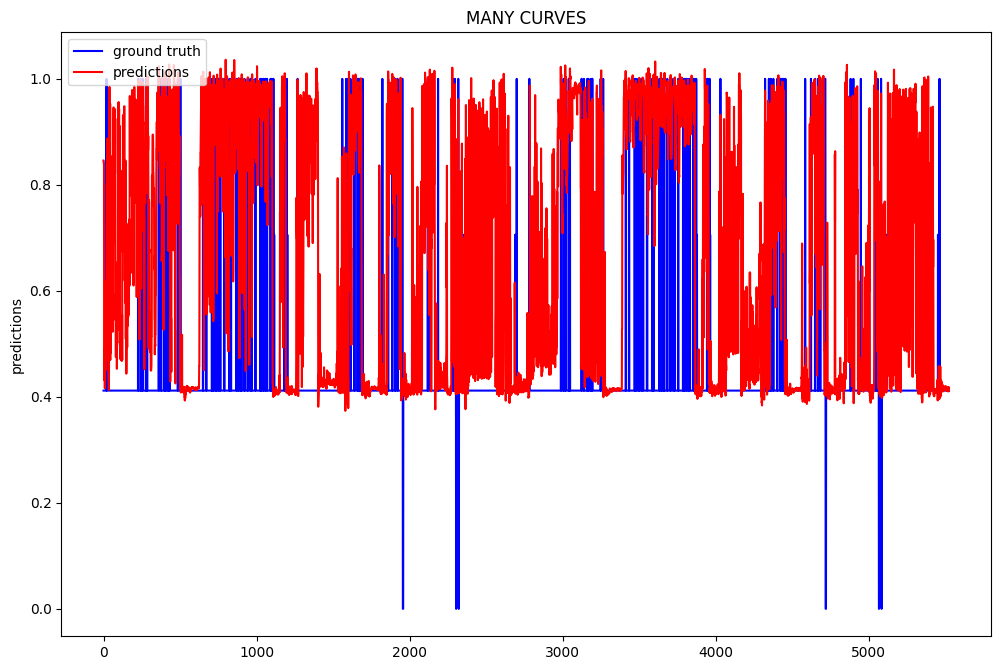

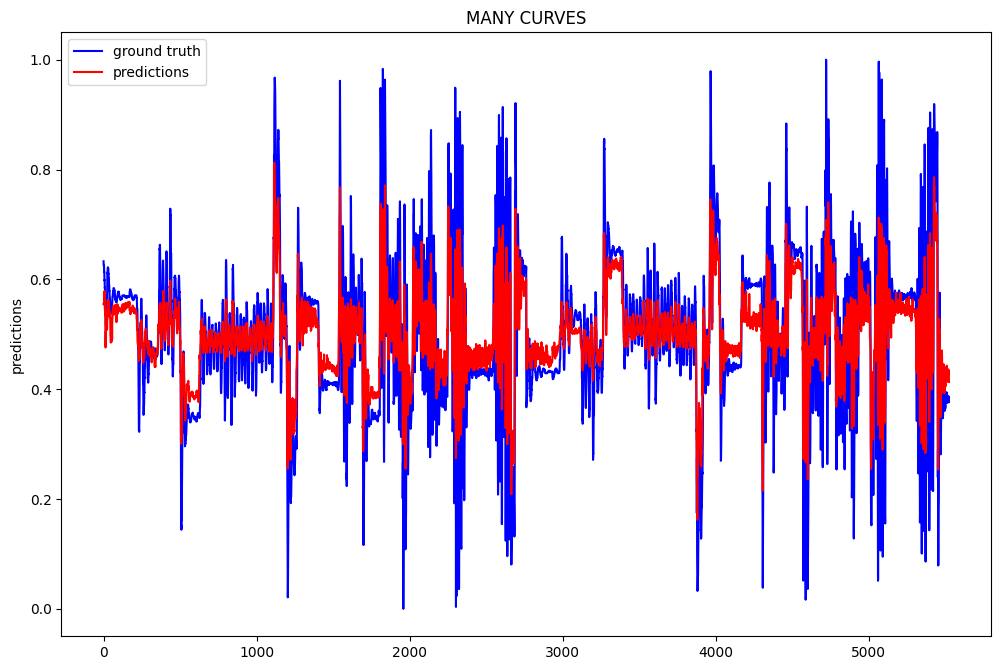

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize
)


regression_model = load_model('20210706-141937_pilotnet_model_100_all_n_extreme_albumentations_cp.h5')

AUGMENTATIONS_TEST = Compose([
    Normalize()
])
normalized_images = []
for image in images_many_curves:
    image = AUGMENTATIONS_TEST(image=image)['image']
    normalized_images.append(image)
normalized_images = np.stack(normalized_images, axis=0)
print(normalized_images.shape)
predictions_train = regression_model.predict(normalized_images)

print(predictions_train[100])
#print(predictions_train[:,1])

print(images_train[100])
print(annotations_simple[100])


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,0], "-b", label="ground truth")
plt.plot(predictions_train[:,0], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('MANY CURVES')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('MANY CURVES')
plt.show()

(7166, 60, 160, 3)
(7166, 2)
(7166, 60, 160, 3)
[0.91740793 0.50708807]
[[[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[201 201 201]
  [201 201 201]
  [202 202 202]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[ 58  57  58]
  [ 58  57  58]
  [ 58  57  57]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 ...

 [[ 49  46  46]
  [ 44  41  41]
  [ 36  33  34]
  ...
  [  9   9   9]
  [  8   8   8]
  [  9   9   9]]

 [[ 49  47  47]
  [ 42  40  40]
  [ 46  43  43]
  ...
  [  9   9   9]
  [  9   8   9]
  [  8   8   8]]

 [[ 48  45  46]
  [ 44  41  42]
  [ 42  39  39]
  ...
  [  9   9   9]
  [  9   9   9]
  [ 11  10  10]]]
[0.41176471 0.73940202]


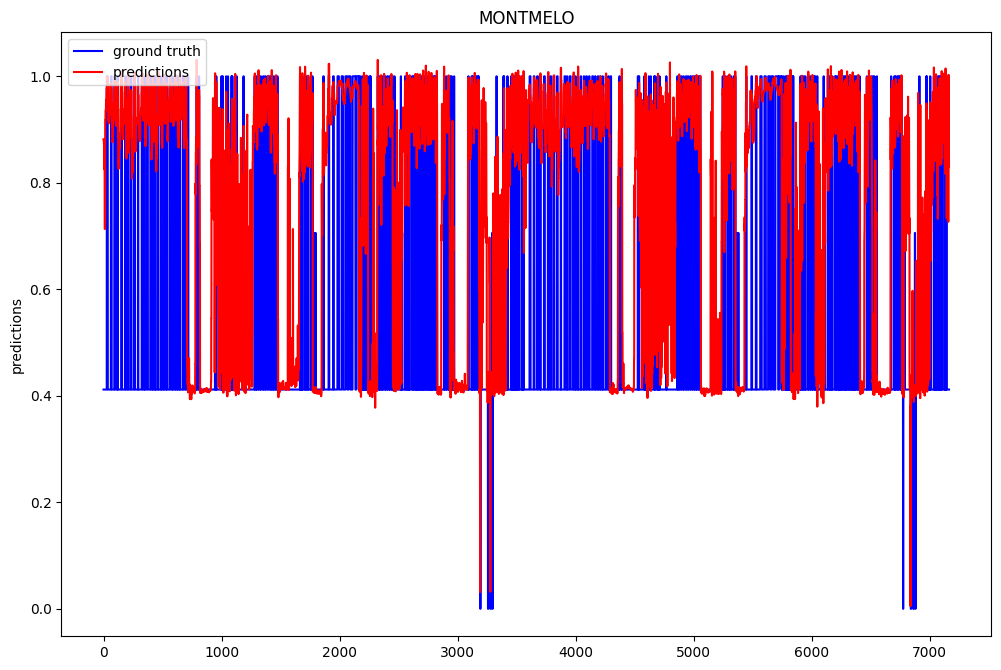

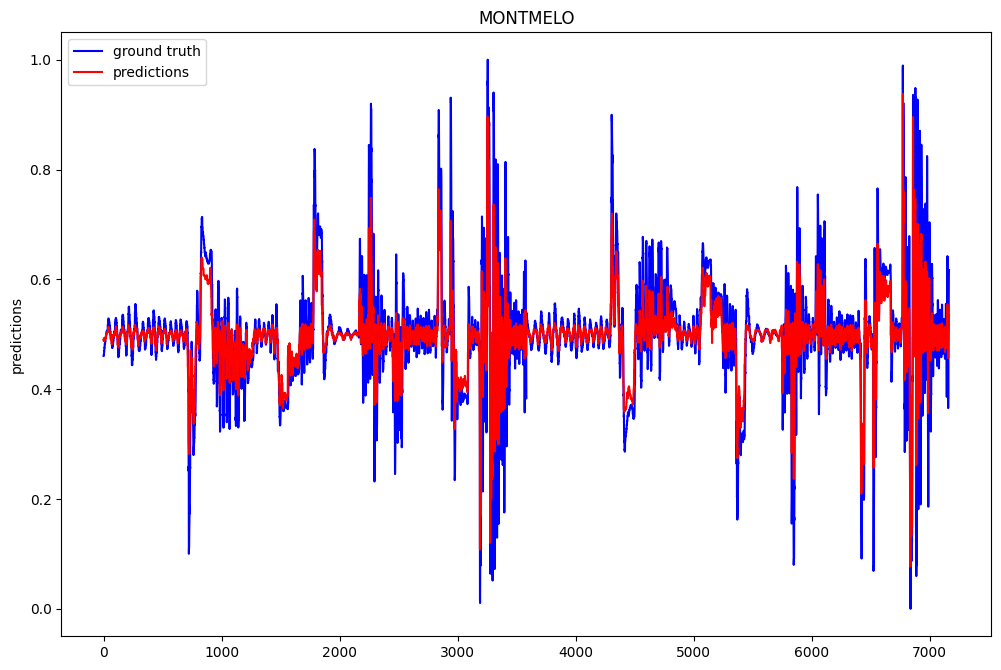

In [8]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '../' + folder + '/'
    list_images = glob.glob(name_folder + '*.jpg')
    #print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[2].split('.jpg')[0]))
    name_file = '../' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in enumerate(data):
        v = data[key]['v']
        w = data[key]['w']
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('montmelo_data')
#print(images)
#print(data)

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
#print(images)
#print(array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
#print(array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])

array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_montmelo = np.stack(array_imgs, axis=0)
annotations_montmelo = np.stack(array_annotations, axis=0)

print(images_montmelo.shape)
print(annotations_montmelo.shape)



import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize
)


regression_model = load_model('20210706-141937_pilotnet_model_100_all_n_extreme_albumentations_cp.h5')

AUGMENTATIONS_TEST = Compose([
    Normalize()
])
normalized_images = []
for image in images_montmelo:
    image = AUGMENTATIONS_TEST(image=image)['image']
    normalized_images.append(image)
normalized_images = np.stack(normalized_images, axis=0)
print(normalized_images.shape)
predictions_train = regression_model.predict(normalized_images)

print(predictions_train[100])
#print(predictions_train[:,1])

print(images_train[100])
print(annotations_train[100])


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_montmelo[:,0], "-b", label="ground truth")
plt.plot(predictions_train[:,0], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('MONTMELO')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_montmelo[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('MONTMELO')
plt.show()
